In [16]:
#standard imports
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

#image imports
from skimage.io import imshow, imread
from skimage.transform import resize
from skimage.color import rgb2gray

#random forest imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_recall_curve, roc_curve

#pickling import
import dill as pickle

#my childhood soccer number
np.random.seed(33)

In [3]:
df = pd.read_csv('data/labels_df.csv')

In [4]:
loaded = np.load('data/image_array.npz')
all_img = loaded['a']
bw_img = loaded['b']

In [5]:
labels = df.masterCategory.copy()
labels = labels.astype('category')
labels = labels.cat.codes

In [46]:
masterCat_dict = {}
for i in range(len(labels.value_counts().index)):
    s = labels.value_counts().index[i]
    t = df.masterCategory.value_counts().index[i]
    masterCat_dict[s] = t
masterCat_dict

{1: 'Apparel',
 0: 'Accessories',
 2: 'Footwear',
 5: 'Personal Care',
 3: 'Free Items',
 6: 'Sporting Goods',
 4: 'Home'}

In [9]:
#shuffle images and target var
shuffle = np.random.choice( np.arange(len(bw_img)), size=len(bw_img), replace=False)
X = bw_img[shuffle]
y = labels.values[shuffle]

#at end, use this to view images in color
colorX = [all_img[ix] for ix in shuffle]

n_train = round(len(X)*.75)

images_train = X[:n_train]
labels_train = y[:n_train]
shuffle_train = shuffle[:n_train]

images_test = X[n_train:]
labels_test = y[n_train:]
shuffle_test = shuffle[n_train:]

In [13]:
clf = RandomForestClassifier(n_estimators = 100, random_state=33)

In [14]:
clf.fit(images_train, labels_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=33, verbose=0,
                       warm_start=False)

In [17]:
with open('random_forest.pkl', 'wb') as my_pickle:
    pickle.dump(clf, my_pickle)

In [20]:
yhat = clf.predict(images_test)
print( 'Accuracy Score: ', accuracy_score(labels_test, yhat) )
print( 'Recall Score: ', recall_score(labels_test, yhat, average='weighted'))

Accuracy Score:  0.9783577339274347
Recall Score:  0.9783577339274347


In [21]:
wrong_id_list = []
pred_cat_list = []
real_cat_list = []
for row_idx in range(len(labels_test)):
    if labels_test[row_idx]!=yhat[row_idx]:
        wrong_id_list.append(row_idx)
        pred_cat_list.append(yhat[row_idx])
        real_cat_list.append(labels_test[row_idx])

arr = np.array([pred_cat_list, real_cat_list])
arr = arr.transpose()

In [22]:
wrong_df = pd.DataFrame( arr, index= wrong_id_list, columns = ['predicted', 'actual'] )
wrong_df.head()

,predicted,actual
6,0,5
19,0,5
114,0,2
148,1,3
192,0,1


In [25]:
# Have a look at False Negatives

FN_accessories = wrong_df[wrong_df.actual == 0]
FN_apparel = wrong_df[wrong_df.actual == 1]
FN_footwear = wrong_df[wrong_df.actual == 2]
FN_personal = wrong_df[wrong_df.actual == 5]
FN_free = wrong_df[wrong_df.actual == 3]
FN_home = wrong_df[wrong_df.actual == 4]
FN_sport = wrong_df[wrong_df.actual == 6]
print( len(FN_accessories), len(FN_apparel), len(FN_footwear), len(FN_free), len(FN_personal), len(FN_sport))

89 47 22 23 49 8


In [48]:
the_truth = FN_accessories.predicted.apply(lambda x: masterCat_dict[x])

In [53]:
the_truth

291            Apparel
386            Apparel
637           Footwear
743      Personal Care
804            Apparel
821            Apparel
948            Apparel
1410           Apparel
1603          Footwear
1658           Apparel
1661           Apparel
2194           Apparel
2294           Apparel
2355           Apparel
2376     Personal Care
2771           Apparel
2783           Apparel
2793           Apparel
2958           Apparel
3012           Apparel
3103           Apparel
3179           Apparel
3267           Apparel
3290           Apparel
3313           Apparel
3397           Apparel
3535           Apparel
3566           Apparel
3700           Apparel
3883           Apparel
             ...      
7523           Apparel
7612           Apparel
7830           Apparel
8132           Apparel
8419           Apparel
8498           Apparel
8560           Apparel
8593           Apparel
8707           Apparel
8858           Apparel
9190           Apparel
9209           Apparel
9211       

In [27]:
accessory_false_neg = list(FN_accessories.index)

In [30]:
orig_index = list(shuffle_test[accessory_false_neg])

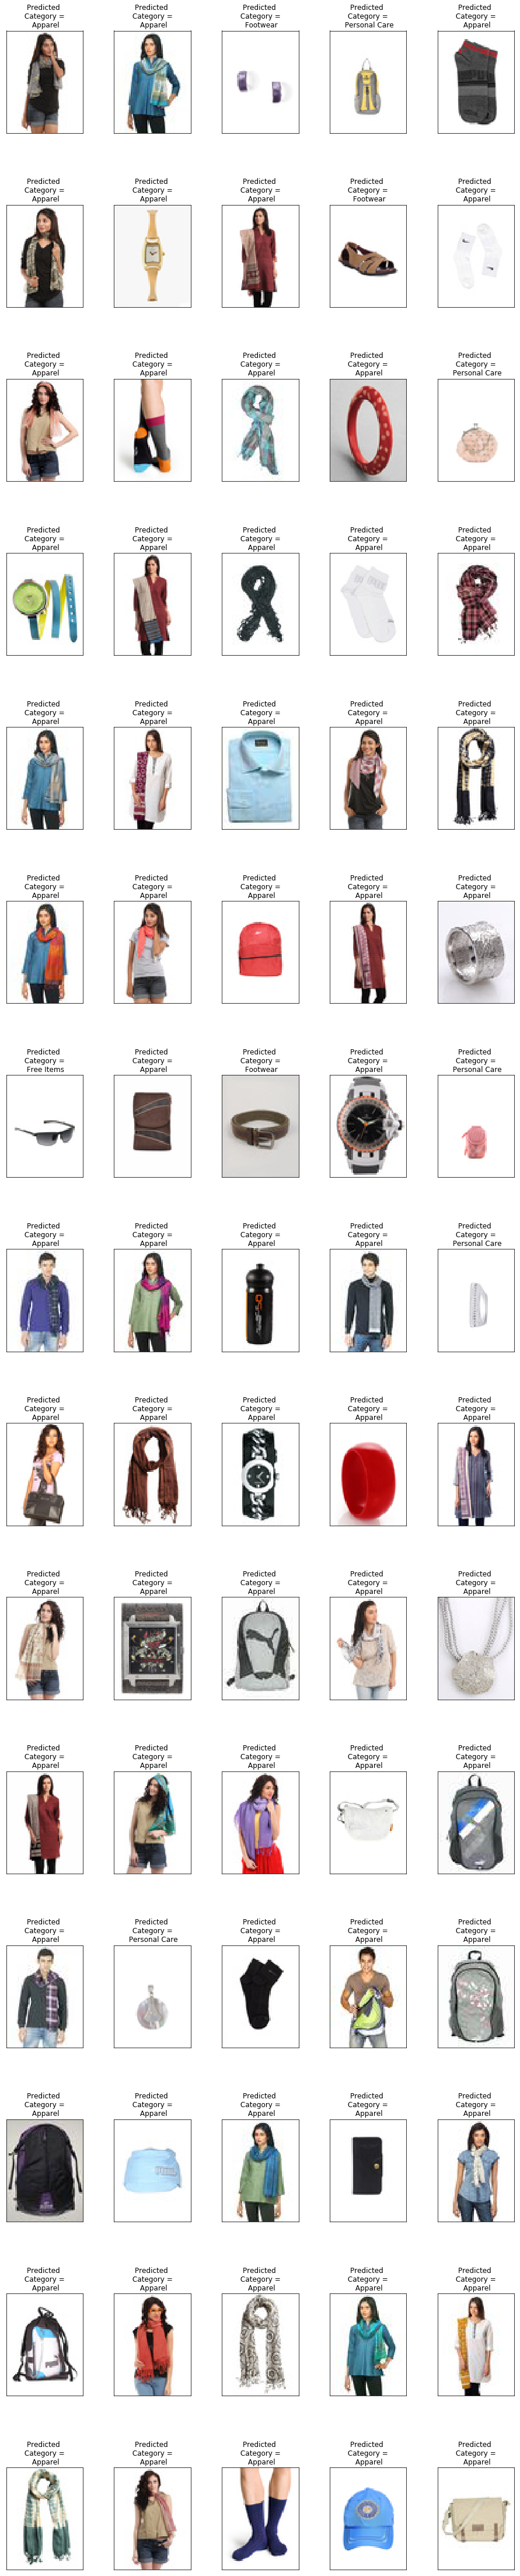

In [56]:
fig, axs = plt.subplots(15, 5, figsize=(12,80))
for i, ax in enumerate(axs.flatten()):
    ax.imshow( all_img[orig_index[i]].reshape(80,60,3)/255 )
    #print(topwear_idx[i])
    ax.set_xticks([])
    ax.set_yticks([]);
    ax.set_title('Predicted \n Category = \n {}'.format(the_truth.values[i]))
plt.subplots_adjust(hspace = 0.7)

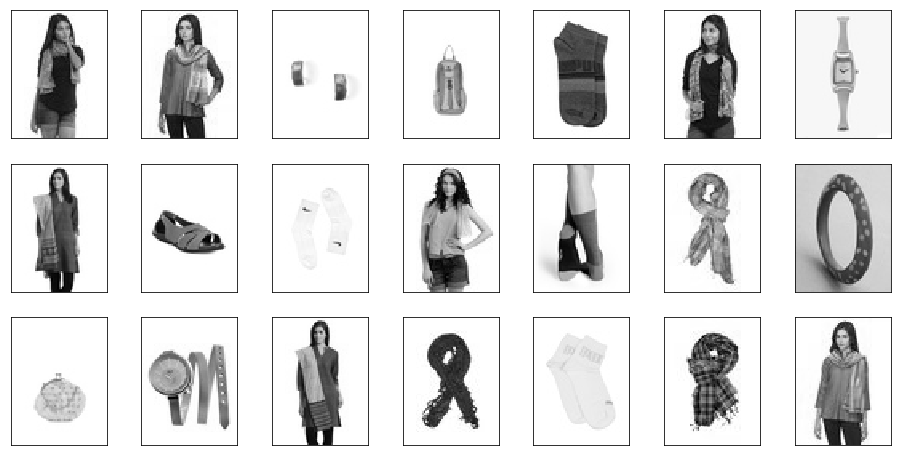

In [37]:
fig, axs = plt.subplots(3, 7, figsize=(16,8))
for i, ax in enumerate(axs.flatten()):
    ax.imshow( bw_img[orig_index[i]].reshape(80,60,1)*[1,1,1]/255 )
    #print(topwear_idx[i])
    ax.set_xticks([])
    ax.set_yticks([]);

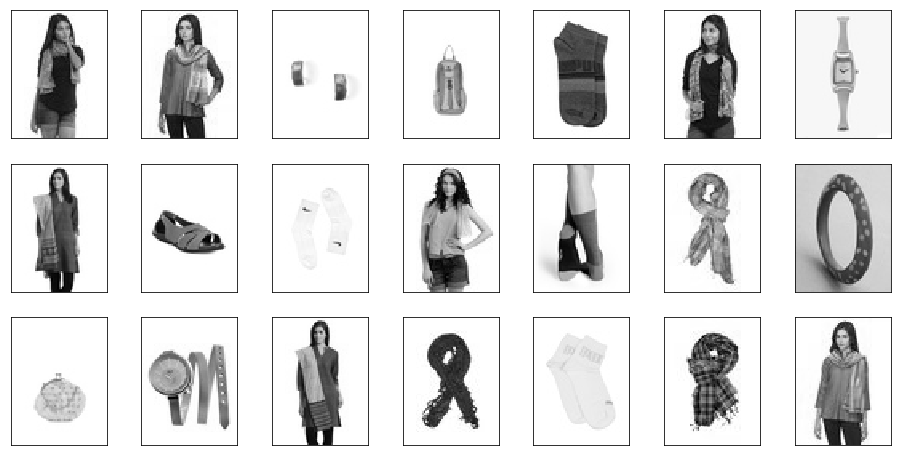

In [35]:
fig, axs = plt.subplots(3, 7, figsize=(16,8))
for i, ax in enumerate(axs.flatten()):
    ax.imshow( images_test[accessory_false_neg[i]].reshape(80,60,1)*[1,1,1]/255 )
    #print(topwear_idx[i])
    ax.set_xticks([])
    ax.set_yticks([]);